In [160]:
import os
from gpuutils import GpuUtils
GpuUtils.allocate(gpu_count=1, framework='keras')

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True) 

import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
np.set_printoptions(precision=3, suppress=True)
from sklearn.preprocessing import MinMaxScaler


GPU 2  will be allocated


In [161]:
#df = pd.read_csv('/mnt/md0/aholmberg/data/raytrace_samples_random.csv')
df = pd.read_csv('/mnt/md0/aholmberg/data/raytrace_samples_angle.csv')
#df['launch_angle'] = np.arctan2(df['launch_vec_r'].to_numpy(), df['launch_vec_z'].to_numpy())
#df['recieve_angle'] = np.arctan2(df['recieve_vec_r'].to_numpy(), df['recieve_vec_z'].to_numpy())
#df.to_csv('/mnt/md0/aholmberg/data/raytrace_samples_angle.csv', index=False)

In [162]:
sc_pos_r = df['source_pos_r'].to_numpy().astype(np.float32)
sc_pos_z = df['source_pos_z'].to_numpy().astype(np.float32)
ant_pos_z = df['antenna_pos_z'].to_numpy().astype(np.float32)
x = np.stack((sc_pos_r, sc_pos_z, ant_pos_z), axis=1)

travel_time = df['travel_time'].to_numpy().astype(np.float32)
path_length = df['path_length'].to_numpy().astype(np.float32)
launch = df['launch_angle'].to_numpy().astype(np.float32)
recieve = df['recieve_angle'].to_numpy().astype(np.float32)
y = np.stack((travel_time, path_length, launch, recieve), axis=1)

typ = df['type'].to_numpy()
#print(launch.shape, recieve.shape, travel_time.shape, path_length.shape)
unique, index, count = np.unique(x, return_counts=True, return_index=True, axis=0)
#print(unique, index, count)
#print(np.unique(count, return_counts=True))
#x[index[count == 1], :]
x_new = np.delete(x, index[count == 1], axis=0)
y_new = np.delete(y, index[count == 1], axis=0)
unique, index, count = np.unique(x_new, return_counts=True, return_index=True, axis=0)
#print(unique, index, count)
#print(np.unique(count, return_counts=True))


In [163]:
x_new  = x_new[0::2,:]
x_train = x_new[:int(x_new.shape[0]*0.8)]
x_test = x_new[int(x_new.shape[0]*0.8):]

y_temp1  = y_new[0::2,:]
y_temp2  = y_new[1::2,:]
y_new = np.zeros((y_temp1.shape[0], 8))

for i in range(4):
    y_new[:,2*i] = y_temp1[:,i]
    y_new[:,2*i+1] = y_temp2[:,i]

y_train = y_new[:int(y_new.shape[0]*0.8)]
y_test = y_new[int(y_new.shape[0]*0.8):]

scaler_x = MinMaxScaler(feature_range=(-1,1))
scaler_x.fit(x_train)
norm_x_train = scaler_x.transform(x_train)
norm_x_test = scaler_x.transform(x_test)

scaler_y = MinMaxScaler(feature_range=(-1,1))
scaler_y.fit(y_train)
norm_y_train = scaler_y.transform(y_train)
norm_y_test = scaler_y.transform(y_test)



In [164]:
"""
temp1 = typ[0::2]
temp2 = typ[1::2]
print(temp1, temp2, typ)
print(temp1.shape, temp2.shape, typ.shape)
unique, counts = np.unique(temp1, return_counts=True)
a = dict(zip(unique, counts))
unique, counts = np.unique(temp2, return_counts=True)
b = dict(zip(unique, counts))
print(a, b)
unique, counts = np.unique(features_train[:,0], return_counts=True)
#c = dict(zip(unique, counts))
print(max(counts))
"""
pass

In [165]:
#model = keras.Model(inputs=inputs, outputs=[output_time, output_length, output_launch, output_recieve], name="full_model")
from raytrace_model_def import get_simple_model
activation = 'tanh'
depth = 3
width = 512
opt = keras.optimizers.Adam(learning_rate=1e-3)
model = get_simple_model(width, depth, activation, optimizer=opt)

In [166]:

print(model.summary())

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               2048      
_________________________________________________________________
dense_40 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_41 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 4104      
Total params: 531,464
Trainable params: 531,464
Non-trainable params: 0
_________________________________________________________________
None


In [167]:
early_stoping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5
)

In [168]:
#model.fit(norm_features_train, [norm_time_train, norm_length_train, norm_launch_train, norm_recieve_train], epochs=5)
model.fit(
    norm_x_train,
    norm_y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.15,
    callbacks=[early_stoping]
    )

Epoch 1/50
1206/1206 [==============================] - 10s 9ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 2/50
1206/1206 [==============================] - 9s 8ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/50
1206/1206 [==============================] - 9s 8ms/step - loss: 9.3369e-04 - val_loss: 9.0982e-04
Epoch 4/50
1206/1206 [==============================] - 11s 9ms/step - loss: 7.6226e-04 - val_loss: 4.7420e-04
Epoch 5/50
1206/1206 [==============================] - 11s 9ms/step - loss: 6.3300e-04 - val_loss: 6.4131e-04
Epoch 6/50
1206/1206 [==============================] - 9s 7ms/step - loss: 6.0068e-04 - val_loss: 4.4966e-04
Epoch 7/50
1206/1206 [==============================] - 9s 8ms/step - loss: 5.0318e-04 - val_loss: 3.6397e-04
Epoch 8/50
1206/1206 [==============================] - 10s 9ms/step - loss: 4.6229e-04 - val_loss: 7.2883e-04
Epoch 9/50
1206/1206 [==============================] - 11s 9ms/step - loss: 8.8116e-04 - val_loss: 2.7647e-04
Epoch 10/50
1206/1206

In [169]:
"""
y_test = model(norm_features_test)
y_time = y_test[0].numpy()
y_length = y_test[1].numpy()
y_launch = y_test[2].numpy()
y_recieve = y_test[3].numpy()
"""
y_test_pred = model(norm_x_test).numpy()
y_test_inv = scaler_y.inverse_transform(y_test_pred)

print(y_test_pred.shape)
y_time = y_test_pred[:,:2]
y_length = y_test_pred[:,2:4]
y_launch = y_test_pred[:,4:6]
y_recieve = y_test_pred[:,6:8]


(45376, 8)


In [170]:
import matplotlib.pyplot as plt
print(y_time.shape, norm_y_test[:,:2].shape)

(45376, 2) (45376, 2)


Text(0, 0.5, 'Network prediction (ns)')

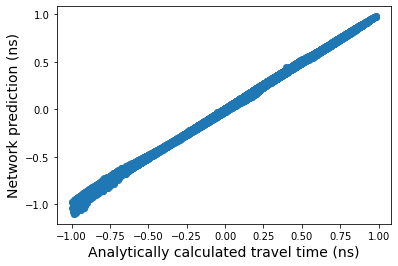

In [171]:
plt.scatter(norm_y_test[:,0], y_time[:,0])
plt.xlabel('Analytically calculated travel time (ns)', size=14)
plt.ylabel('Network prediction (ns)', size=14)
#plt.savefig('model_pred_1.svg')

Text(0, 0.5, 'Network prediction (ns)')

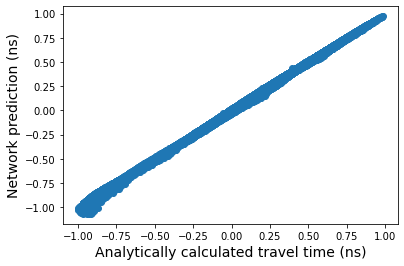

In [172]:
plt.scatter(norm_y_test[:,2], y_length[:,0])
plt.xlabel('Analytically calculated travel time (ns)', size=14)
plt.ylabel('Network prediction (ns)', size=14)
#plt.savefig('model_pred_2.svg')

In [173]:
#diff_deg = y_test - y_test_inv

diff = y_test - y_test_inv
diff_deg = np.copy(diff)
diff_deg[:,4:] = np.degrees(diff_deg[:, 4:])

sol = ['time_sol_1:', 
       'time_sol_2:',
       'length_sol_1:',
       'length_sol_2:',
       'launch_sol_1:',
       'launch_sol_2:',
       'recieve_sol_1:',
       'recieve_sol_2:']

for i in range(8):
    #mean = np.mean(diff[:,i])
    #std = np.std(diff[:,i])
    mean = np.mean(diff_deg[:,i])
    std = np.std(diff_deg[:,i])
    print(sol[i] + f' mean: {mean:.4f}  std: {std:.4f}')

time_sol_1: mean: 7.9208  std: 103.0650
time_sol_2: mean: 22.3157  std: 81.2756
length_sol_1: mean: 3.4934  std: 17.6304
length_sol_2: mean: 10.8157  std: 20.0470
launch_sol_1: mean: -0.1720  std: 2.2102
launch_sol_2: mean: -0.0239  std: 1.0747
recieve_sol_1: mean: -0.1322  std: 2.4385
recieve_sol_2: mean: 0.1078  std: 1.5187


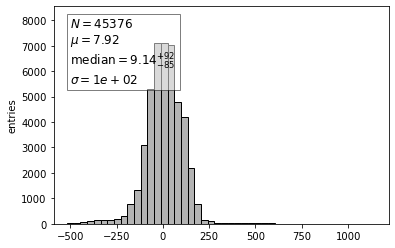

In [174]:
from radiotools import plthelpers as php
fix, ax = php.get_histogram(diff_deg[:,0], bins=50)
plt.show()
#print(norm_time_train)